In [1]:
#import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
import jax
import juniper as jp

from juniper.GaussKernel import GaussKernel
from juniper.LinearKernelCombination import LinearKernelCombination

from juniper.steps.NeuralField import NeuralField
from juniper.steps.StaticGain import StaticGain
from juniper.steps.DemoInput import DemoInput
from juniper.steps.Projection import Projection
from juniper.steps.Sum import Sum


from demo.demo3 import demo3

In [2]:
print("Computing devices found by JAX:")
print(jax.local_devices())

Computing devices found by JAX:
[CpuDevice(id=0)]


In [3]:
arch = jp.Architecture.get_arch()

In [4]:
jp.Architecture.delete_arch()
arch = jp.Architecture.get_arch()

#params
space_shape = (294, 447)
feature_shape = (10,)
feature_map_shape = feature_shape+space_shape

# Prepare Input
red_pill = DemoInput("red_pill", {"shape":feature_map_shape, "sigma":(0.1,30,30), "amplitude":4, "center": (2,0,0)})
blue_pill = DemoInput("blue_pill", {"shape":feature_map_shape, "sigma":(0.1,30,30), "amplitude":4, "center": (8,0,0)})
feature_cue = DemoInput("feature_cue", {"shape":feature_shape, "sigma":(0.1,), "amplitude":2, "center": (2,)})

# kernel
exc_kernel2d = GaussKernel({"sigma": (30,30), "amplitude": 6, "normalized": True})
inh_kernel2d = GaussKernel({"sigma": (45,45), "amplitude": -3, "normalized": True})
nf_kernel2d = LinearKernelCombination({"kernels": [exc_kernel2d, inh_kernel2d], "wheights": [0.5,0.5]})
exc_kernel3d = GaussKernel({"sigma": (0.1,30,30), "amplitude": 7, "normalized": True})
inh_kernel3d = GaussKernel({"sigma": (0.1,45,45), "amplitude": -3, "normalized": True})
nf_kernel3d = LinearKernelCombination({"kernels": [exc_kernel3d, inh_kernel3d], "wheights": [0.5,0.5]})

# Prepare Neural Fields
nf0 = NeuralField("Attention Field", {"shape": space_shape, "resting_level": -5, "global_inhibition": -0.00, "tau": 0.05,  "input_noise_gain": 0.5, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": nf_kernel2d})
nf1 = NeuralField("Action Field", {"shape": space_shape, "resting_level": -5, "global_inhibition": -0.00, "tau": 0.05,  "input_noise_gain": 0.1, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": nf_kernel2d})
nf2 = NeuralField("Feature Map Field", {"shape": feature_map_shape, "resting_level": -5, "global_inhibition": -0.000, "tau": 0.05,  "input_noise_gain": 0.5, "sigmoid": "AbsSigmoid", "beta": 100, "theta":0, "lateral_kernel_convolution": nf_kernel3d})

# Static steps
st0 = StaticGain("st0", {"factor": 6})
st1 = StaticGain("st1", {"factor": 2})
sum0 = Sum("sum0", {})
proj0 = Projection("proj0", {"input_shape": feature_shape, "output_shape": feature_map_shape, "axis": (1,2), "order":(0,1,2), "compression_type": "Maximum"})
proj1 = Projection("proj1", {"input_shape": feature_map_shape, "output_shape": space_shape, "axis":(0), "order": (0,1), "compression_type": "Maximum"})
proj2 = Projection("proj2", {"input_shape": feature_map_shape, "output_shape": space_shape, "axis":(0), "order": (0,1), "compression_type": "Maximum"})

# connections
red_pill >> sum0
blue_pill >> sum0
sum0 >> proj2
proj2 >> nf0
red_pill >> nf2
blue_pill >> nf2

feature_cue >> proj0
proj0 >> nf2

nf2 >> proj1
proj1 >> st1
st1 >> nf0
nf0 >> st0
st0 >> nf1

arch.compile()

Loading saved buffers...


<img src="demo/img/demo3_sketch.png" alt="demo sketch" width="500">

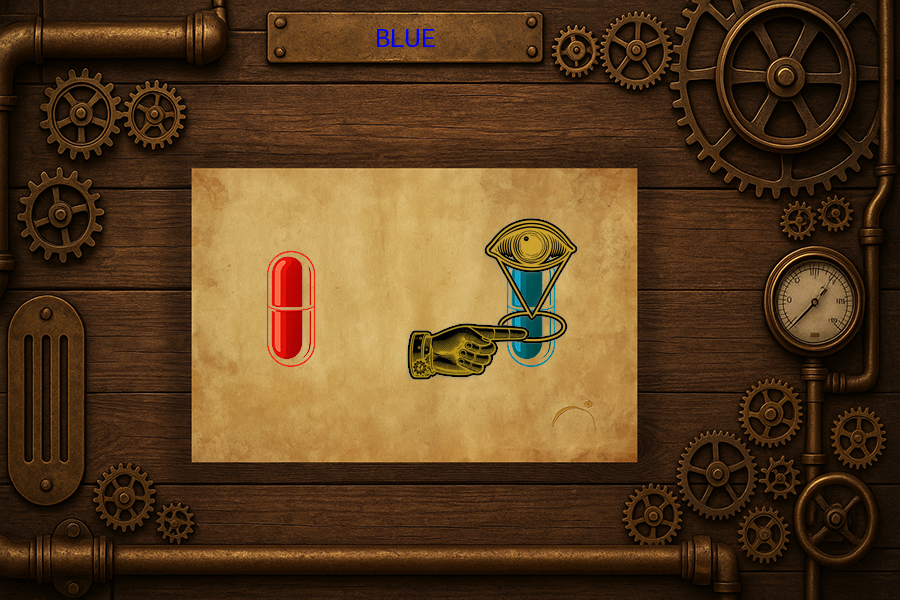

In [5]:
num_steps = 80
demo = demo3(arch, eye_field="Attention Field", hand_field="Action Field")
recording = demo.run(num_steps)

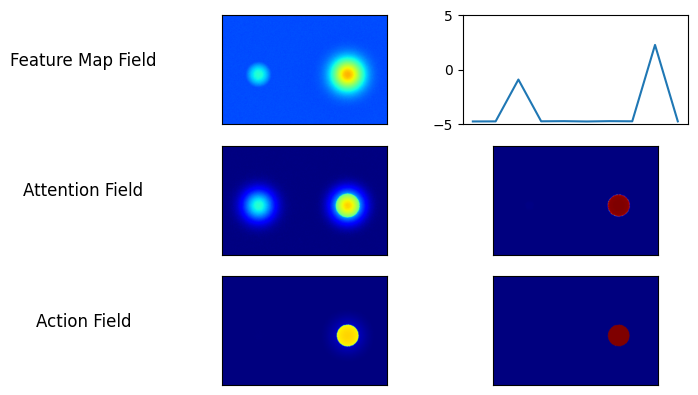

In [6]:
demo.plot()